# Data Description
- Wage and other data for a group of 3000 male workers in the Mid-Atlantic region.
- There are 3000 rows.
- There are 11 variables:
    - year: Year that wage information was recorded
    - age: Age of worker
    - maritl: A factor with levels ‘1. Never Married’, ‘2. Married’, ‘3. ‘3. Widowed’, ‘4. Divorced’ and ‘5. Separated’ indicating marital status
    - race: A factor with levels ‘1. White’, ‘2. Black’, ‘3. Asian’ and ‘4. Other’ indicating race
    - education: A factor with levels ‘1. < HS Grad’, ‘2. HS Grad’, ‘3. Some College’, ‘4. College Grad’ and ‘5. Advanced Degree’ indicating education level
    - region: Region of the country (mid-atlantic only)
    - jobclass: A factor with levels ‘1. Industrial’ and ‘2. Information’ indicating type of job
    - health: A factor with levels ‘1. <=Good’ and ‘2. >=Very Good’ indicating health level of worker
    - health_ins: A factor with levels ‘1. Yes’ and ‘2. No’ indicating whether worker has health insurance
    - logwage: Log of workers wage
    - wage: Workers raw wage

# Load Packages and Data

In [1]:
%%capture
pip install ISLP

In [2]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, bs, ns,
                         ModelSpec as MS)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

In [3]:
Wage = load_data('Wage')
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
Wage.describe().round(3)

,year,age,logwage,wage
count,3000.000,3000.000,3000.000,3000.000
mean,2005.791,42.415,4.654,111.704
std,2.026,11.542,0.352,41.729
min,2003.000,18.000,3.000,20.086
25%,2004.000,33.750,4.447,85.384
50%,2006.000,42.000,4.653,104.922
75%,2008.000,51.000,4.857,128.680
max,2009.000,80.000,5.763,318.342


# Polynomial Regression and Step Functions

In [5]:
y = Wage['wage']; age = Wage['age']

- We use the `poly()` function to create a model matrix
that will fit a $4$th degree polynomial in `age`.

In [6]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


- The polynomial is created using the `poly()` function, which builds a transformer called `Poly()` for evaluating polynomials at new data points. Here, `poly()` is a helper function that sets up the transformation, while `Poly()` performs the actual calculations. 
- In the code, the first line calls the `fit()` method on the `Wage` dataframe. This recalibrates and saves any necessary parameters for `Poly()` based on the training data. These parameters will be used in future evaluations of the `transform()` method, as seen in the second line and the plotting function below.

We now create a grid of values for `age` at which we want
predictions.

In [7]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})
age_df.head()

,age
0,18.000000
1,18.626263
2,19.252525
3,19.878788
4,20.505051


- To plot the data and include the fit from the fourth-degree polynomial, we’ll first create a function.
- This function will handle the necessary components for the plot, taking in a model specification (defined by a transform) and a grid of `age` values.
- It will generate a fitted curve along with 95% confidence bands. By allowing a `basis` argument, we can easily produce and plot results with different transforms, including the splines we'll explore soon.

In [8]:
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age, y, facecolor='gray', alpha=0.5)
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

- We add an `alpha` argument to `ax.scatter()` to make the points semi-transparent, helping to visually indicate density. Notice the use of the `zip()` function in the `for` loop, which allows us to easily bundle different colors and line types for three lines to plot together. 
- Now, we'll use this function to plot the fit of the fourth-degree polynomial.

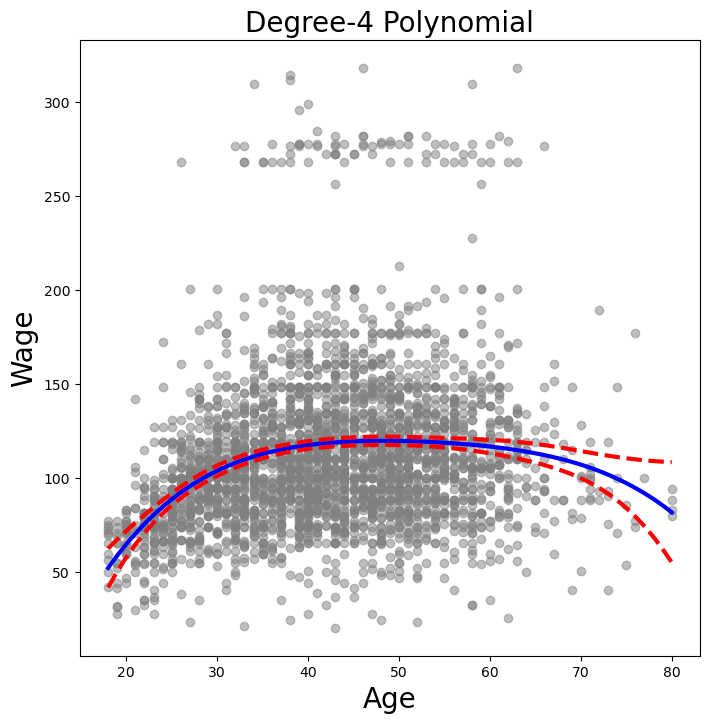

In [9]:
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial');

- When using polynomial regression, we need to choose the polynomial degree carefully. Instead of guessing, we can make a systematic decision using hypothesis tests.
- We'll fit models from linear (degree one) to degree five polynomials to find the simplest model that adequately explains the relationship between `wage` and `age`. We’ll use the `anova_lm()` function to conduct a series of ANOVA tests, which evaluate the null hypothesis that a simpler model ($ \mathcal{M}_1 $) sufficiently explains the data against the alternative that a more complex model ($ \mathcal{M}_2 $) is necessary. This determination relies on an F-test.
- For the test to be valid, the models $ \mathcal{M}_1 $ and $ \mathcal{M}_2 $ must be nested, meaning the predictors in $ \mathcal{M}_1 $ must be a subset of those in $ \mathcal{M}_2 $. We will fit five polynomial models and compare each simpler model to the next more complex one.

In [10]:
models = [MS([poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


- Notice the `*` in the `anova_lm()` line. This function accepts a variable number of non-keyword arguments, and when supplying multiple fitted models as a list, you need to prefix it with `*`.
- The p-value comparing the linear model (`models[0]`) to the quadratic model (`models[1]`) is effectively zero, indicating that a linear fit isn't sufficient. (Note that it can be confusing since `models[1]` is quadratic.) Similarly, the p-value when comparing the quadratic model to the cubic model (`models[2]`) is very low (0.0017), suggesting that the quadratic fit also fails to be sufficient. The p-value for the cubic and degree-four polynomial models (`models[2]` and `models[3]`) is around 5%, while the degree-five polynomial (`models[4]`) shows a higher p-value of 0.37, indicating it's likely unnecessary. Thus, either a cubic or quartic polynomial fits the data well, while lower or higher-order models are not justified.
- Instead of using `anova()`, we could have also obtained these p-values more succinctly by using the fact that `poly()` generates orthogonal polynomials.

In [11]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


- Notice that the p-values are identical, and in fact, the square of the t-statistics equals the F-statistics from the `anova_lm()` function. For example:

In [12]:
(-11.983)**2

143.59228900000002

- The ANOVA method works with or without orthogonal polynomials, as long as the models are nested. For instance, we can use `anova_lm()` to compare three models, each with a linear term in `education` and a polynomial in `age` of different degrees:

In [13]:
models = [MS(['education', poly('age', degree=d)]) for d in range(1, 4)]
XEs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


- Instead of using hypothesis tests and ANOVA, we could also determine the polynomial degree through cross-validation.
- Next, we focus on predicting whether an individual earns more than $250,000 annually. We'll first create the appropriate response vector, then use the `glm()` function with the binomial family to fit a polynomial logistic regression model.

In [80]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


- We make predictions using the `get_prediction()` method.

In [81]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

- We plot the estimated relationship.

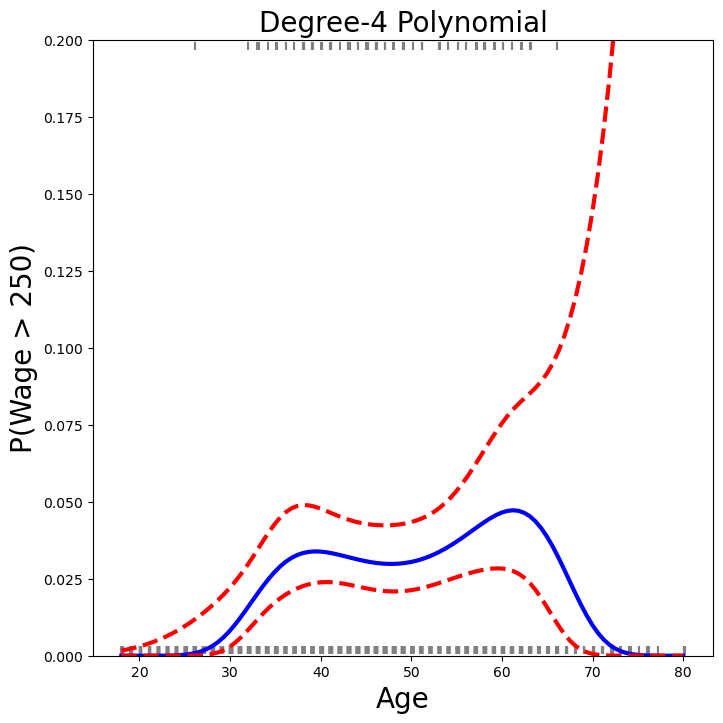

In [82]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]],
                 ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

- We've marked `age` values for observations with `wage` above 250,000 as gray dots at the top of the plot and those below 250,000 at the bottom. To avoid overlapping points, we added some jitter to the `age` values. This visualization is known as a *rug plot*.
- To fit a step function, we first use the `pd.qcut()` function to discretize `age` into quantiles. Then, we apply `pd.get_dummies()` to create columns for this categorical variable. Unlike the typical method, this function includes all columns for the categorical variable instead of dropping one level.

In [68]:
cut_age = pd.qcut(age, 4)
cut_age.head()

0    (17.999, 33.75]
1    (17.999, 33.75]
2       (42.0, 51.0]
3       (42.0, 51.0]
4       (42.0, 51.0]
Name: age, dtype: category
Categories (4, interval[float64, right]): [(17.999, 33.75] < (33.75, 42.0] < (42.0, 51.0] < (51.0, 80.0]]

In [18]:
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


- Here, `pd.qcut()` automatically selects cut points at the 25%, 50%, and 75% quantiles, creating four age categories. We could also specify our own quantiles instead of using `4`. For cuts not based on quantiles, we would use `pd.cut()`.
- Both `pd.qcut()` and `pd.cut()` return an ordered categorical variable. The regression model then generates dummy variables for use in the regression. Since `age` is the only variable, the coefficient of $94,158.40 represents the average salary for those under 33.75 years old, while the other coefficients indicate average salaries for the other age groups. We can make predictions and plots just like we did with the polynomial fit.

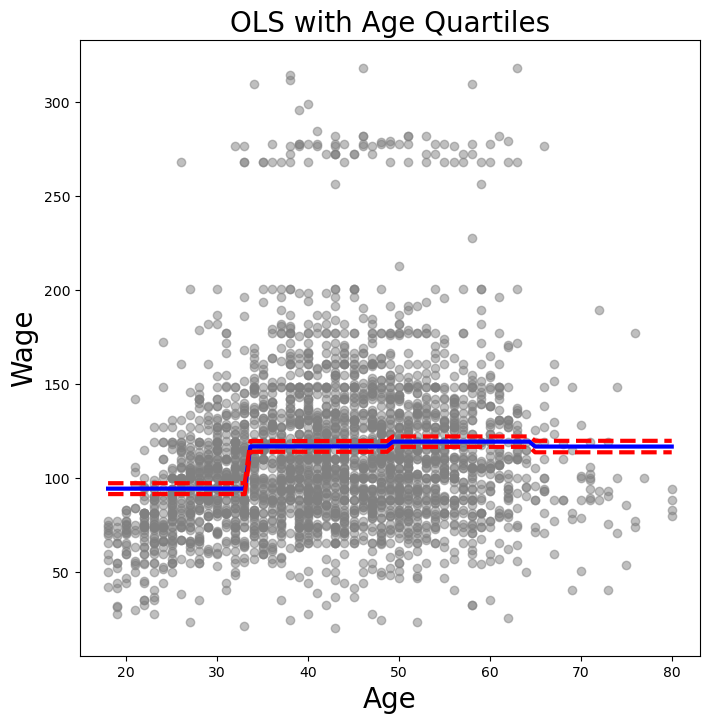

In [78]:
# Define a custom basis transformation function
class CustomBasis:
    def __init__(self, dummies):
        self.dummies = dummies

    def transform(self, df):
        age_cut = pd.qcut(df['age'], 4)
        return pd.get_dummies(age_cut).values

# Create an instance of CustomBasis
basis = CustomBasis(cut_age_dummies)
plot_wage_fit(age_df, basis, 'OLS with Age Quartiles');

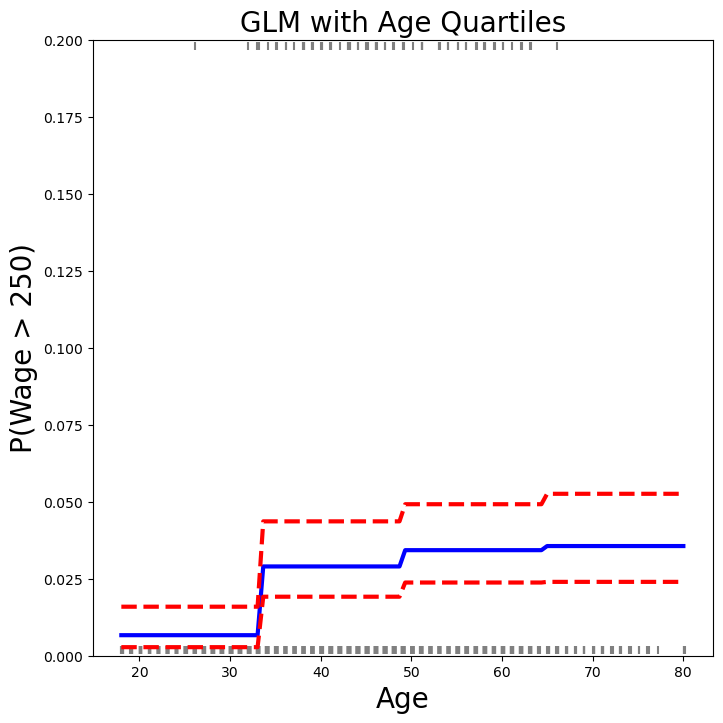

In [76]:
high_earn_model = sm.GLM(high_earn, pd.get_dummies(cut_age), family=sm.families.Binomial()).fit()
# Custom basis transformation for prediction
def basis_transform(df):
    age_cut = pd.qcut(df['age'], 4)
    return pd.get_dummies(age_cut).values

newX = basis_transform(age_df)
preds = high_earn_model.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

# Plotting
fig, ax = subplots(figsize=(8, 8))
rng = np.random.default_rng(0)
ax.scatter(age + 0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean, bands[:, 0], bands[:, 1]],
                   ['b', 'r--', 'r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('GLM with Age Quartiles', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0, 0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

# Splines
- To fit regression splines, we use transforms from the `ISLP` package, which wraps the actual spline evaluation functions found in `scipy.interpolate`, similar to how `Poly()` and `PCA()` work.
- Regression splines are fitted by creating a matrix of basis functions. The `BSpline()` function generates this matrix using a specified set of knots, producing cubic B-splines by default. To change the spline degree, simply use the `degree` argument.

In [85]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [94]:
bs_age.head(20)

,"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[0]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[1]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[2]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[3]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[4]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[5]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[6]"
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.002915,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,0.000000,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,0.000000,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,0.000000,0.000000,0.034014,0.508194,0.426542,0.031250,0.0
5,0.000000,0.000000,0.007347,0.376679,0.530224,0.085750,0.0
6,0.000000,0.000000,0.139320,0.628472,0.230208,0.002000,0.0
7,0.000000,0.137741,0.629111,0.228819,0.004329,0.000000,0.0
8,0.000000,0.000000,0.233299,0.624931,0.141738,0.000031,0.0
9,0.000000,0.000000,0.017415,0.444923,0.483662,0.054000,0.0


- This gives us a seven-column matrix, typical for a cubic-spline basis with 3 interior knots. We can create this matrix using the `bs()` function, making it easy to add to a model matrix. Now, we fit a cubic spline model to the `Wage` data.

In [20]:
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


- The column names are quite lengthy, limiting the printed summary. You can shorten them during creation using the `name` argument.

In [21]:
bs_age = MS([bs('age', internal_knots=[25,40,60], name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


- There are 6 instead of 7 spline coefficients as `bs()` defaults to `intercept=False`, assuming an intercept in the model. Hence, one basis function is discarded after creating the spline basis with specified knots.
- The complexity of the spline could be set using the `df` (degrees of freedom) option. For example, with 3 knots, the spline basis has 6 degrees of freedom. If we set `df=6`, `bs()` will create a spline with 3 knots selected at equal quantiles of the training data, best viewed using `Bspline()`.

In [108]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

- When you request six degrees of freedom, the transform selects knots at ages 33.75, 42.0, and 51.0. These represent the 25th, 50th, and 75th percentiles of `age`.
- Using B-splines doesn't restrict us to cubic polynomials (i.e., `degree=3`). For instance, `degree=0` produces piecewise constant functions, similar to our previous `pd.qcut()` example.


In [95]:
bs_age0 = MS([bs('age', df=3, degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


In [96]:
BSpline(df=3, degree=0).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

- This model should be compared with the one in cell [15] where we used `qcut()` to create four bins at the 25%, 50%, and 75% quantiles of `age`.
- Here, because we set `df=3` for degree-zero splines, the knots are also at these three quantiles. Despite differently presented coefficients, it's the same underlying coding.
- For instance, the first coefficient is the same in both models and represents the average response in the first bin. The second coefficient here ($94.158 + 22.349 = 116.507$, versus 116.611 in cell [15]) is a little different due to the binning process. `qcut()` uses $\leq$, while `bs()` uses $<$ to assign bin membership, hence the slight discrepancy.

- To fit a natural spline, use the `NaturalSpline()` transform and the `ns()` helper. This example fits a natural spline with five degrees of freedom (not counting the intercept), after which the results are plotted.

In [110]:
ns_age = MS([ns('age', df=4)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,58.5563,4.235,13.827,0.000
"ns(age, df=4)[0]",60.4619,4.190,14.430,0.000
"ns(age, df=4)[1]",41.9633,4.372,9.597,0.000
"ns(age, df=4)[2]",97.0202,10.386,9.341,0.000
"ns(age, df=4)[3]",9.7734,8.657,1.129,0.259


In [109]:
NaturalSpline(df=4).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

- We plot the natural spline using our plotting function.

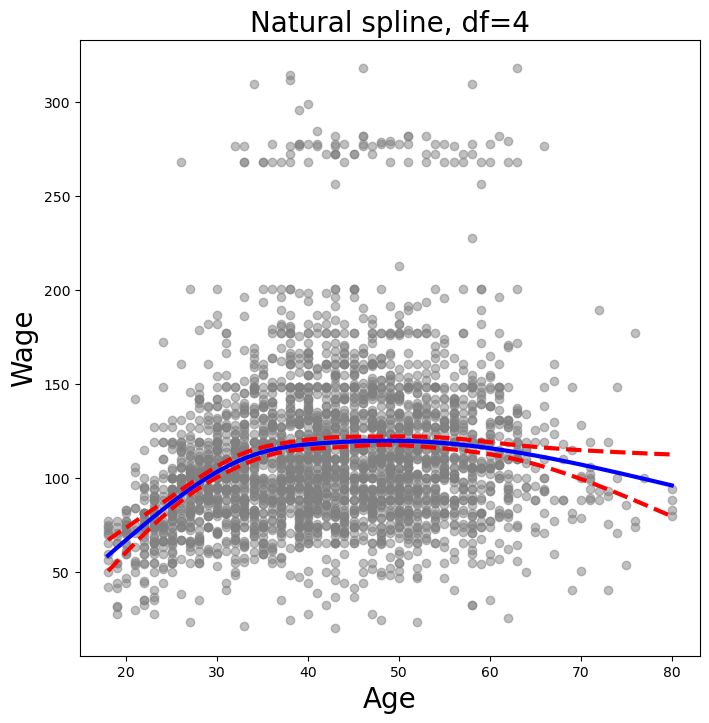

In [114]:
plot_wage_fit(age_df, ns_age, 'Natural spline, df=4');

# Smoothing Splines and GAMs
- A smoothing spline, a specific type of Generalized Additive Model (GAM) with squared-error loss for one feature, can be fit in Python using the `pygam` package.
- Each column in a model matrix corresponds to a smoothing operation: 's' for smoothing spline, 'l' for linear, and 'f' for categorical variables.
- `s` applies to the first column of a feature matrix. In the example below, it is applied to a matrix with a single column: `X_age`. `lam` is the penalty parameter $\lambda$.

In [26]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

- The `pygam` library usually requires a matrix of features, so we convert `age` from a vector (one-dimensional array) to a matrix (two-dimensional array). In the `reshape()` method, `-1` instructs `numpy` to determine the size of that dimension based on the other shape values.
- The fit alters with the smoothing parameter `lam`. Using `np.logspace()`, which spaces points evenly on a logarithmic scale, we adjust `lam` from $10^{-2}$ to $10^6$.

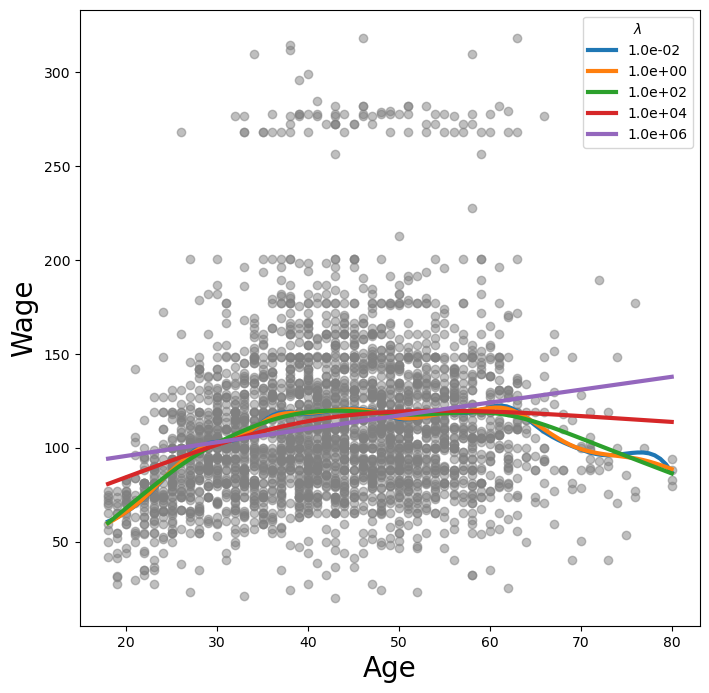

In [27]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

- The `pygam` package can perform a search for an optimal smoothing parameter.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


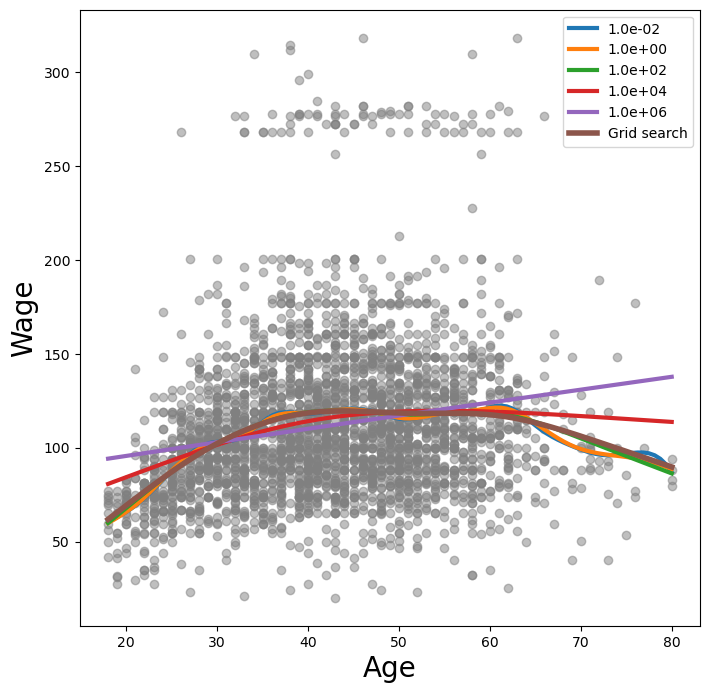

In [28]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

- Alternatively, with the `ISLP.pygam` package, we can set the smoothing spline's degrees of freedom.
- We determine a $\lambda$ value that approximately provides four degrees of freedom. These degrees, which include the unpenalized intercept and linear term of the smoothing spline, are at least two.

In [29]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.0000001000011824

- We can vary the degrees of freedom similar to the previous plot.
- We account for the fact that these smoothing splines always include an intercept term, so we adjust the desired degrees of freedom by adding one. Thus, a `df` value of one results in just a linear fit.

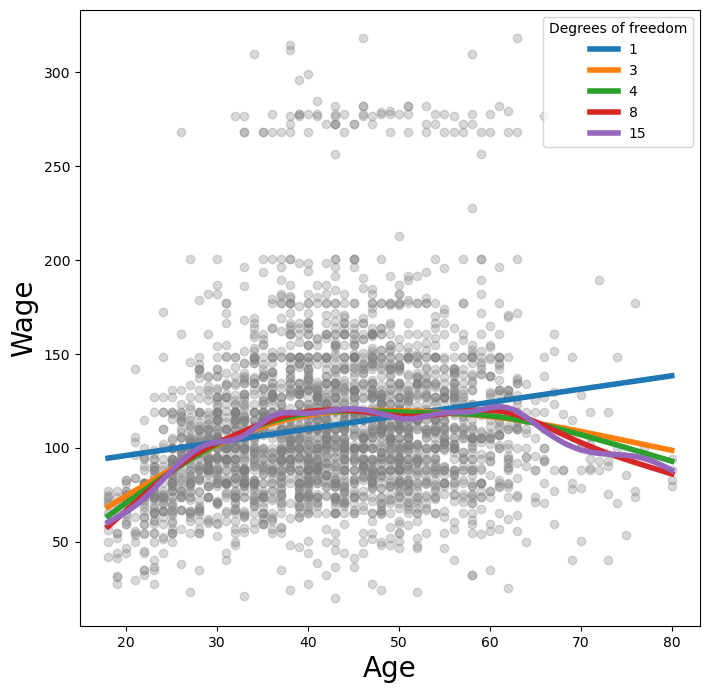

In [30]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20); ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');

## Additive Models with Several Terms
- Generalized additive models excel in fitting more flexible multivariate regression models than linear models. We illustrated two methods: one using natural splines and piecewise constant functions, and the other using the `pygam` package and smoothing splines.
- We now manually fit a GAM to predict `wage` using natural spline functions of `year` and `age`, and treating `education` as a qualitative predictor. This large linear regression model, built with a specific set of basis functions, can be created using the `sm.OLS()` function.
- We construct the model matrix more manually, as we want to separately access the components when crafting partial dependence plots.

In [31]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

- In this case, `NaturalSpline()` supports the `ns()` helper function. We used all columns of the indicator matrix for the `education` categorical variable, making an intercept unnecessary. Finally, we stacked the three matrices horizontally to form the `X_bh` model matrix.
- Now, we'll demonstrate how to construct partial dependence plots for each term in our basic GAM using specified grids for `age` and `year`. We can do this manually by predicting with new $X$ matrices while keeping all features but one fixed at a time.

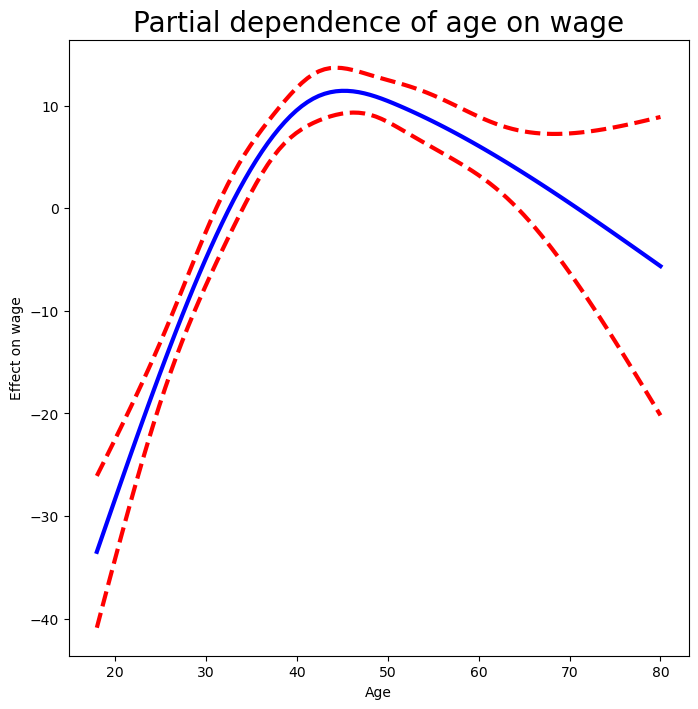

In [32]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

- What we did above is create a new prediction matrix. All columns, except those for `age`, are constant and set to their training-data means. The four `age` columns are filled with the natural spline basis evaluated at the 100 `age_grid` values.
    * We created an `age` grid with 100 points and made a matrix `X_age_bh` with 100 rows and the same quantity of columns as `X_bh`.
    * We filled each row of this matrix with the means of the original columns.
    * We replaced the first four columns, which represent `age`, with the natural spline basis evaluated at the `age_grid` values.
- The rest of the steps should be familiar.
- We also explored how `year` affects `wage`, following the same process.

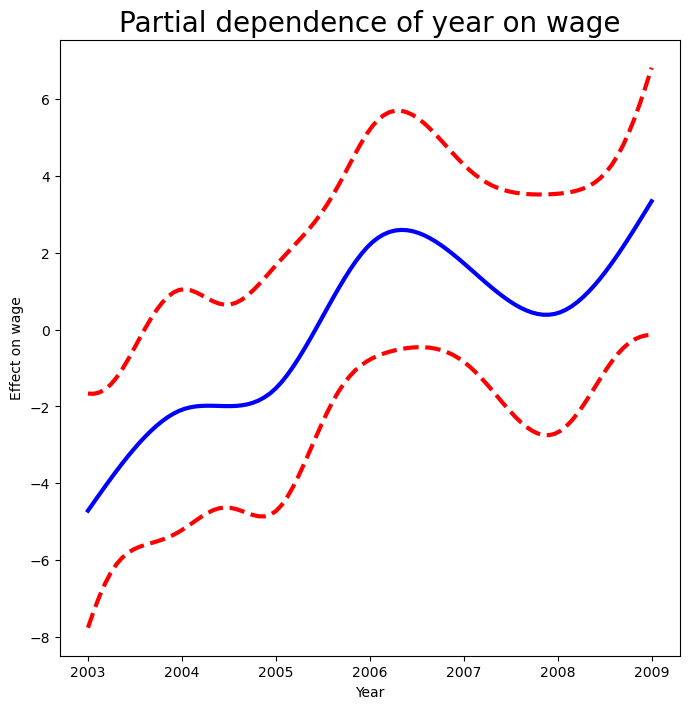

In [33]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

- We now fit the model using smoothing splines instead of natural splines. All terms in the model are fit simultaneously, accounting for each other to explain the response. The `pygam` package requires matrices, so we convert the categorical series `education` to its array representation using the `cat.codes` attribute. As `year` has only 7 unique values, we use only seven basis functions for it.

In [34]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

- The two `s_gam()` terms lead to smoothing spline fits, using a default (yet somewhat arbitrary) value for $\lambda$ (`lam=0.6`). For the categorical term `education`, mentioned using a `f_gam()` term, we set `lam=0` to avoid any shrinkage. We generate a partial dependence plot for `age` to observe the effects of these choices.
- The plot values are produced by the `pygam` package. The `ISLP.pygam` function `plot_gam()` simplifies generating partial-dependence plots compared to our previous example with natural splines.

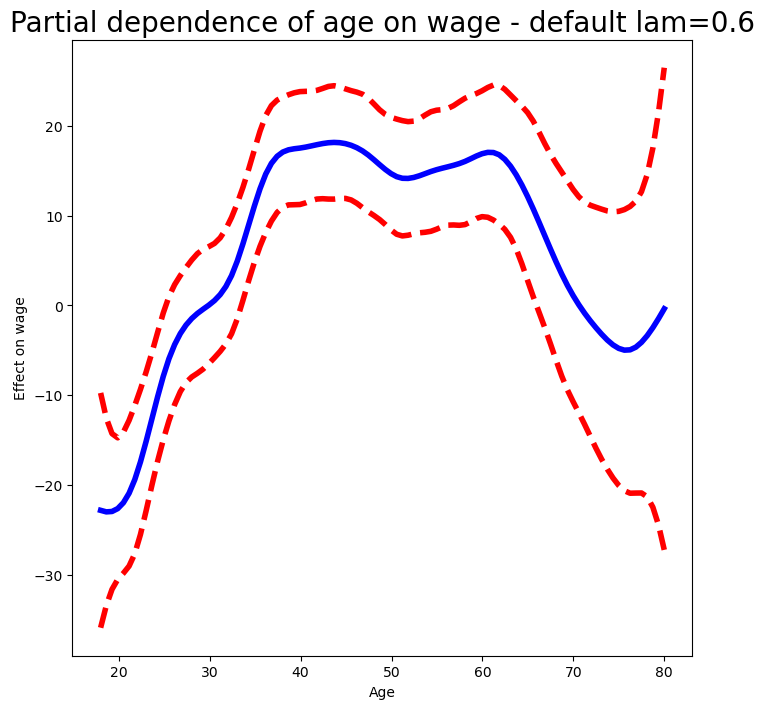

In [35]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20);

- The function appears somewhat fluctuating. It's more intuitive to specify the `df` rather than a `lam` value. We refit a GAM using four degrees of freedom each for `age` and `year`. Remember, the addition of one below considers the intercept of the smoothing spline.

In [36]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

- Remember that updating `age_term.lam` also updates it in `gam_full.terms[0]`, and the same applies for `year_term.lam`.
- Replotting for `age` reveals a smoother curve. Let's also plot for `year`.

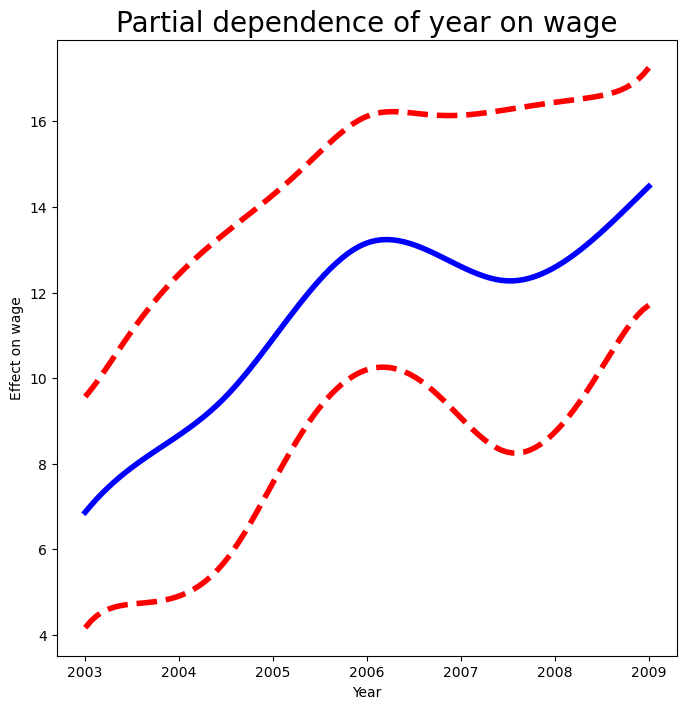

In [37]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

- Lastly, we plot `education`, which is a categorical variable. The partial dependence plot is adapted and more suitable for the set of fitted constants for each level of this variable.

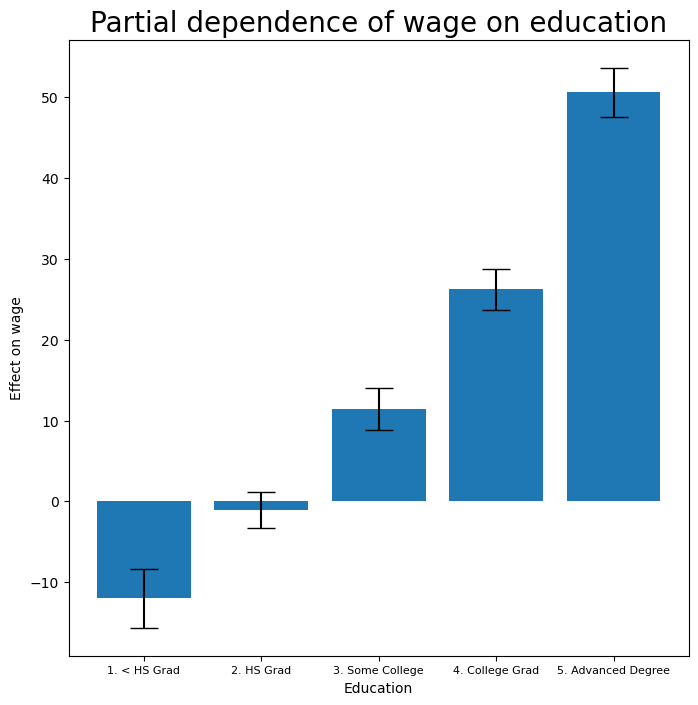

In [38]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

## ANOVA Tests for Additive Models
- In all our models, the function of `year` seems linear. We can conduct a series of ANOVA tests to determine which model is best: a GAM that excludes `

In [39]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0) +
                       f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

- Note our use of `age_term` in the expressions above. We do this because we previously set `lam` in this term for four degrees of freedom.
- To directly evaluate the impact of `year`, we perform an ANOVA on the three models fitted above.

In [40]:
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


- We discover conclusive evidence that a GAM with a linear function in `year` is superior to a GAM excluding `year` entirely ($p$-value= 0.002). However, there's no evidence suggesting the need for a non-linear function of `year` ($p$-value=0.435). In other words, based on this ANOVA, $\mathcal{M}_2$ is the preferred model.
- We can also repeat this process for `age` and find strong evidence supporting the need for a non-linear term for `age`.

In [41]:
gam_0 = LinearGAM(year_term +
                  f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
                       year_term +
                       f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


- There is a (verbose) `summary()` method for the GAM fit.

In [42]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/tmp/ipykernel_2428/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


- We can make predictions from `gam` objects, similarly to `lm` objects, using the `predict()` method for the `gam` class. In this case, we're making predictions on the training set.

In [43]:
Yhat = gam_full.predict(Xgam)

- In order to fit a logistic regression GAM, we use `LogisticGAM()` 
from `pygam`.

In [44]:
gam_logit = LogisticGAM(age_term + 
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

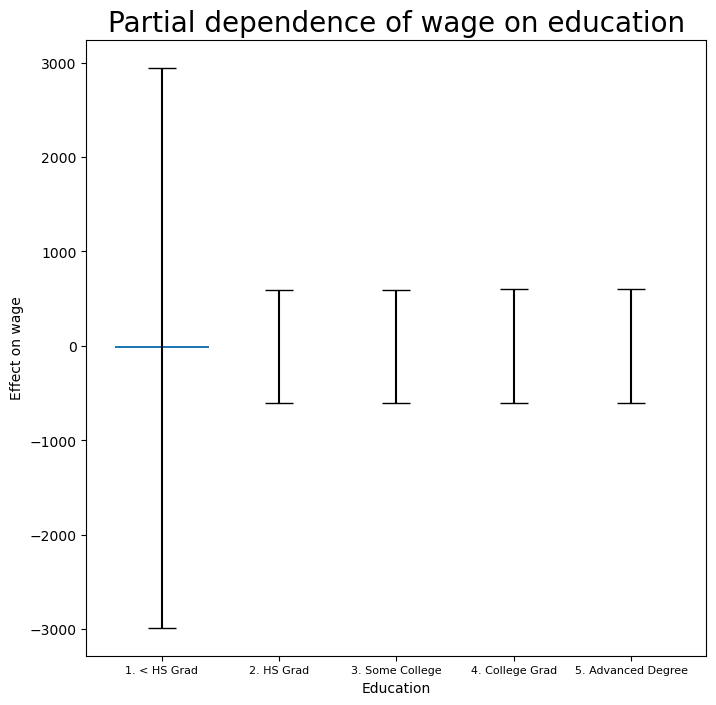

In [45]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

- The model appears quite flat, with particularly high error bars for the first category. Let's examine the data more closely.

In [46]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


- There aren't any high earners in the first education category, making it difficult for the model to fit. We'll fit a logistic regression GAM excluding all observations in this category, providing more reasonable results.
- We could subset the model matrix to do this, but this won't remove the column from `Xgam`. Even though we can figure out which column corresponds to this feature, we reestablish the model matrix on this smaller subset for the sake of reproducibility.

In [47]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
                         Wage_['year'],
                         Wage_['education'].cat.codes-1])
high_earn_ = Wage_['high_earn']

- In the penultimate line above, we subtract one from the category codes due to a `pygam` bug. This simply relabels the education values and doesn't affect the fit.
- Now let's fit the model.

In [48]:
gam_logit_ = LogisticGAM(age_term +
                         year_term +
                         f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

- Now that we've removed those observations, let's examine the effect of `education`, `year`, and `age` on the high earner status.

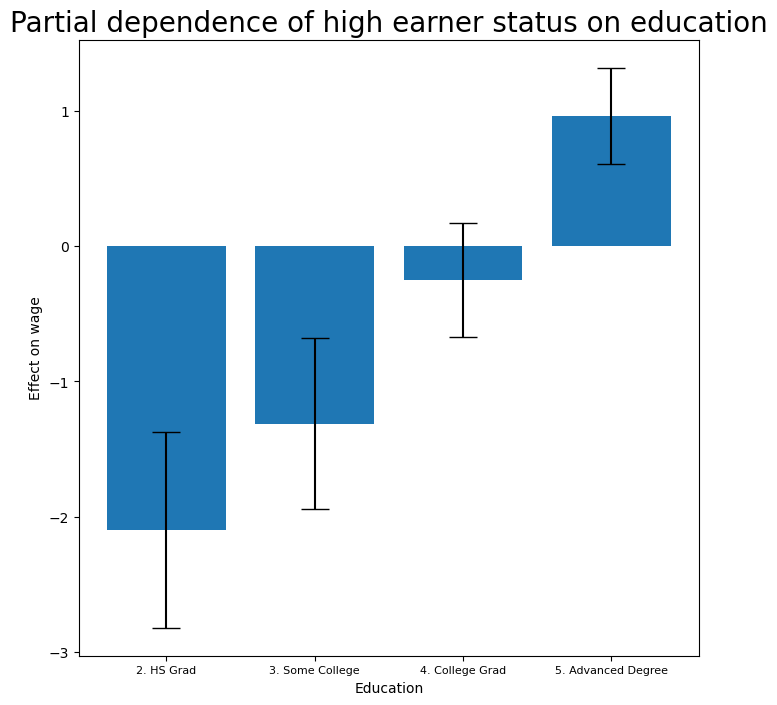

In [49]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:], fontsize=8);

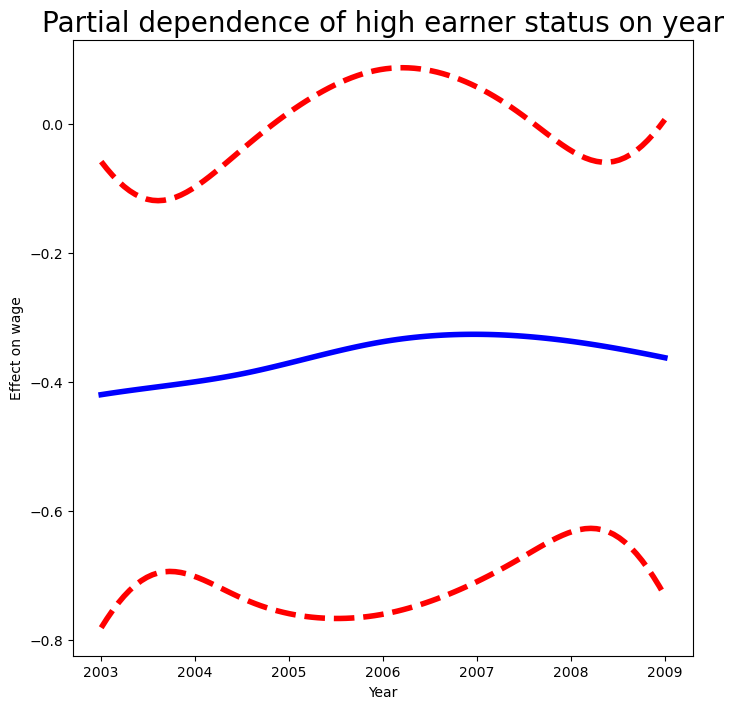

In [50]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year', fontsize=20);

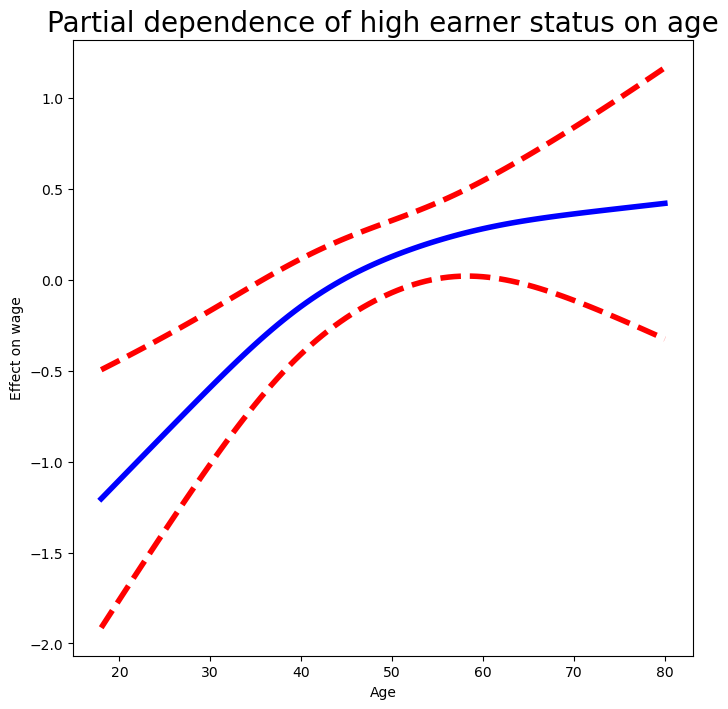

In [51]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age', fontsize=20);

# Local Regression
- We demonstrate local regression using the `lowess()` function from `sm.nonparametric`. While some GAM implementations allow local regression operators, `pygam` doesn't.
- We fit local linear regression models using spans of 0.2 and 0.5, meaning each neighborhood consists of 20% or 50% of the observations. As anticipated, a span of 0.5 results in a smoother model than 0.2.

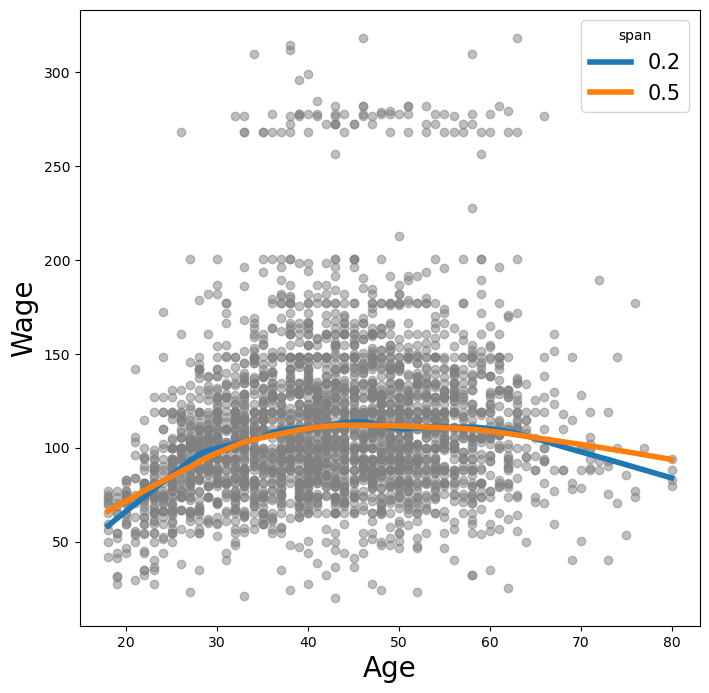

In [52]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age,
                    frac=span,
                    xvals=age_grid)
    ax.plot(age_grid,
            fitted,
            label='{:.1f}'.format(span),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);